In [1]:
'''EEG cleaning script
saves segmented and cleaned files
**requires neuroscan recording and subject beh files (sessions 3 and 4)**
neuroscan and EEG -> segment_trials.ipynb -> (SVD.ipynb/subBehPK.ipynb)'''
import curryreader as cr
import os
from hdf5storage import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.signal as signal
from sklearn.decomposition import FastICA
from scipy.stats import zscore
import pandas as pd
import ast

In [2]:
def getFeats(filename):
    '''Builds feat array and feature index for subject based on csv file'''
    blockdf = pd.read_csv(filename)
    stimfeat = []
    answerarray = []
    mlans = []
    refind = []
    resp = []
    for i in blockdf['Experiment Data']: ###read tuple of experiment data
        i = ast.literal_eval(i)
        if 'Trial' in i:
            answerarray.append(i['Correct Answer'])
            mlans.append(i['Model Response'])
            for l in i['Features']:
                stimfeat.append(l+': '+str(i['Features'][l]))
            stimfeat.append('Response Cue')
            stimfeat.append('Pass or Keep')
            refind.append(i['Reference Index'])
            resp.append(i['Response'])
    resp = np.array(resp)
    stimfeat = np.array(stimfeat,dtype = 'object') #### array of all features + response cue in order
    answerarray = np.array(answerarray) #### array of all features + response cue in order
    mlans = np.array(mlans,dtype = 'int')
    refind = np.array(refind,dtype = 'int')
    print(stimfeat.shape)
    return stimfeat, answerarray, mlans, refind ,resp

def clean_events_array(sub_event):
    '''Remove repeated button press, if different buttons were pressed returns False'''
    keep = np.where((sub_event[:,1] == 1200001) | (sub_event[:,1] == 1200002))[0]
    if len(set(sub_event[:,1][np.where(sub_event[:,1] == 1200002)[0][0]+1:np.where(sub_event[:,1] == 1200002)[0][-1]])) == 1:
        resp1 = [np.where(sub_event[:,1] == 1200002)[0][0]+1]
    else:
        return sub_event
    if len(set(sub_event[:,1][np.where(sub_event[:,1] == 1200002)[0][-1]+1:])) == 1:
        resp2 = [np.where(sub_event[:,1] == 1200002)[0][-1]+1]
    else:
        return sub_event
    return sub_event[sorted(np.concatenate((keep,np.array(resp1),np.array(resp2)),axis =0)),:]

def getEEG(fname):
	'''return eeg data'''
	currydata = cr.read(fname, plotdata = 0, verbosity = 1)
	eegdata = currydata['data'][:,0:128]
	sr = currydata['info']['samplingfreq']
	photocells=currydata['data'][:,132:134]
	labels = currydata['labels']
	chanloc = currydata['sensorpos']
	events = currydata['events']
	return eegdata,sr,events,photocells,labels,chanloc

def eventdata(photocells,events,trialsperfile,maxpc):

    '''Recover photocell onsets, trial offsets, response time, response choice, pass or keep time, pass or keep choice from photocell and curry'''
    x = zscore(photocells[:,0])
    temp = np.where(x > 1)[0]
    temp2 = np.diff(temp)
    temp3 = np.where(temp2 > 1)[0]
    stimonsets = np.zeros(len(temp3)+1) # all photocells of trial except last
    stimonsets[0] = temp[0]
    stimonsets[1:] = temp[temp3+1]

    x = zscore(photocells[:,1])
    temp = np.where(x > 1)[0]
    temp2 = np.diff(temp)
    temp3 = np.where(temp2 > 1)[0]
    trialoffsets = np.zeros(len(temp3)+1) # last photocell of trial
    trialoffsets[0] = temp[0]
    trialoffsets[1:] = temp[temp3+1]


    trialonsets = np.zeros(trialsperfile) # photocell times for trial start
    responsetime = np.zeros(trialsperfile) # photocell times for time of response
    responsewindow = np.zeros(trialsperfile) # photocell times for response window
    # mlfbtime = np.full(trialsperfile,np.nan) # photocell times for when ml response appear if applicable
    featureonset = np.zeros((trialsperfile,maxpc)) ## photocell times for when 3 features and response window appears
    # expbytrial = np.full((trialsperfile,maxpc),np.nan)


    trial = stimonsets[np.where((stimonsets<trialoffsets[0]))]
    trialonsets[0] = trial[0] # 0 is the first photocell
    responsetime[0] = trialoffsets[0] - trial[4] # 4 is the response photocell time between rw and pk (maybe use event time)
    responsewindow[0] = trial[3]
    try:
        featureonset[0] = trial[0:maxpc]
    except IndexError:
        pass
    # for ind,t in enumerate(trial):
    #     expbytrial[0][ind] = t

    # try:
    #     mlfbtime[0] = trial[5]
    # except IndexError:
    #     pass
    for j,i in enumerate(trialoffsets[1:]):
        trial = stimonsets[np.where((stimonsets<i) & (stimonsets > trialoffsets[j]))]
        trialonsets[j+1] = trial[0]
        try:
            responsetime[j+1] = trial[4] - trial[3]
            responsewindow[j+1] = trial[3]
            featureonset[j+1] = trial[0:maxpc]
        except IndexError:
            pass
        # for ind,t in enumerate(trial):
        #     expbytrial[j+1][ind] = t
        # try:
        #     mlfbtime[j+1] = trial[5]
        # except IndexError:
        #     pass
    featureonset=featureonset.reshape(trialsperfile*maxpc)

    # segment_events = []
    alt_responsetime = np.zeros(trialsperfile) # response time using events
    alt_trialonsets = np.zeros(trialsperfile) # trial start using events
    responsechoice = np.full(trialsperfile,-1) # response choice using events
    passkeepchoice = np.full(trialsperfile,-1) # choice to pass or keep using events
    passkeeptime = np.zeros(trialsperfile) # pass or keep response time using events
    clean_events = np.full((trialsperfile*5,4),np.nan)

    featsend = np.zeros(trialsperfile)
    pkwindow = np.zeros(trialsperfile)

    # pork = np.where(events[:,1] == 1200002)[0][1::2]
    # starts = np.where(events[:,1] == 1200001)[0]
    onlyPc = events[np.where((events[:,1] == 1200001) | (events[:,1] == 1200002))[0],:]
    tst = np.where(onlyPc[:,1] == 1200001)[0]
    starts = []
    pork = []
    for i in tst:
        if list(onlyPc[i:i+3,1]) != [1200001.0, 1200002.0, 1200002.0]:
            print('Bad Trial')
            starts.append(-1)
            pork.append(-1)
            continue
        sInd = onlyPc[i,0]
        if len(np.unique(np.where(events == sInd)[0])) > 1:
            print('error')
        starts.append(np.where(events == sInd)[0][0])
        try:
            eInd = onlyPc[i+3,0]
            pork.append(np.where(events == eInd)[0][0])

        except IndexError:
            print('Last trial')
            pork.append(events.shape[0])

            
            
        # print(events[starts[-1]:pork[-1]])


    for ind,(start,end) in enumerate(zip(starts,pork)):
        # if (end-start)
        if start == -1 or end == -1: ## check for valid trial based on reaching end
            print('Invalid trial',ind)
            # print(events[end,0]-events[start,0])
            trialonsets[ind] = 0
            trialoffsets[ind] = 0
            featsend[ind] = 0
            pkwindow[ind] = 0
            continue
        sub_events = events[start:end,:]

        if len(sub_events[:,1]) > 5: ## check if same multiple presses
            print('Checking Trial',ind,'for repeat press')
            sub_events = clean_events_array(sub_events)

        if len(sub_events[:,1]) > 5: ## will trigger if different presses
            print(events[start:end,:])
            print(f'Different presses at trial {ind}')
            trialonsets[ind] = 0
            trialoffsets[ind] = 0
            featsend[ind] = 0
            pkwindow[ind] = 0
        elif len(sub_events[:,1]) < 5: ## will trigger with short trial
            print('Invalid trial',ind)
            pkwindow[ind] = 0
            featsend[ind] = sub_events[-1,0]
            trialoffsets[ind] = 0
        elif sub_events[0,1] != 1200001 or sub_events[1,1] != 1200002 or sub_events[3,1] != 1200002: # will trigger if it does not fit proper format
            trialonsets[ind] = 0
            trialoffsets[ind] = 0
            featsend[ind] = 0
            pkwindow[ind] = 0
        else:
            if sub_events[2,1] not in [32,2]:
                print(sub_events)
            alt_trialonsets[ind] = sub_events[0,0]
            alt_responsetime[ind] = sub_events[2,0] - responsewindow[ind]
            responsechoice[ind] = sub_events[2,1]
            passkeepchoice[ind] = sub_events[4,1]
            passkeeptime[ind] = sub_events[4,0] - sub_events[3,0]
            for i,e in enumerate(sub_events):
                clean_events[i] = e
            featsend[ind] = sub_events[3,0]
            pkwindow[ind] = sub_events[3,0]

            # print(sub_events)

    responsechoice[np.where(responsechoice == [32])] = 0
    responsechoice[np.where(responsechoice == [2])] = 1
    passkeepchoice[np.where(passkeepchoice == [32])] = 0
    passkeepchoice[np.where(passkeepchoice == [2])] = 1

    temp = np.zeros(trialsperfile)
    for i,j in enumerate(trialoffsets):
        # if i
        temp[i] = j
    trialoffsets = temp
    # stimonsets.shape, trialonsets.shape, trialoffsets.shape, responsetime.shape, responsechoice.shape,passkeeptime.shape,passkeepchoice.shape
    return stimonsets, trialonsets, trialoffsets, alt_responsetime, responsechoice,passkeeptime,passkeepchoice, featsend, pkwindow, featureonset

def segmentdata(eegdata,featonset,pc,prestim,poststim):
    '''Return array of trial label as numerical id, feature position label as numerical id, and time as an array before and after feature onset'''
    triallabel = np.zeros(len(featonset))
    poslabel = np.zeros(len(featonset))
    blockdata = np.zeros((len(featonset),int(prestim+poststim),128))
    for j in range(len(featonset)):
        triallabel[j*pc:(j+1)*pc] = j
    for j in range(len(featonset)):
        if eegdata[featonset.astype(int)[j]-prestim:featonset.astype(int)[j]+poststim,:].shape[0] != 0:
            blockdata[j,:,:] = eegdata[featonset.astype(int)[j]-prestim:featonset.astype(int)[j]+poststim,:]
        else:
            blockdata[j,:,:] = np.full_like(blockdata[j,:,:],0) #0 or np.nan?
        poslabel[j] = int(j%pc)
    time = np.arange(-prestim,poststim)
    return blockdata,triallabel,poslabel,time

def avref(datax,bchan=[]):
	""" Assumes datax is time by channels"""
	nchan = np.shape(datax)[1]
	gchan = np.setdiff1d(range(nchan),bchan)
	ref = np.mean(datax[:,gchan],axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	if len(bchan) != 0:
		datax[:,bchan] = 0
	return datax

def baselinecorrect(data,baselinesamps):
	""" 	Corrects for baseline offset in evoked potentials    
	INPUT: 	data is the data 
			baselinesamps is the indices of the samples to use as a baseline
			e.g., range(200)
	OUTPUT: databc baseline corrected data 
	Automatically calculates the mean of the baseline interval
	and then removes it from the timeseries """
#
#find the mean 
	base = np.mean(data[baselinesamps,:],axis = 0)
	nrows = np.size(data,axis = 0)	
	ncols = np.size(data,axis = 1)	
	databc = np.zeros((nrows,ncols))
	for j in range(ncols):
		databc[:,j] = data[:,j] - base[j]
	return databc

def ica_cleanup(goodepochdata,noisy_chans,fail_chans = [],corr_threshold = 0.4,icavar_threshold = 0.5,maxiter = 10000, tolerance = 1e-6):
    ntrials = np.shape(goodepochdata)[0]
    ntime = np.shape(goodepochdata)[1]
    nchan = np.shape(goodepochdata)[2]
    use_chans = np.setdiff1d(range(nchan),fail_chans)
    nusechan = len(use_chans)
    if len(fail_chans) != 0:
        for j in range(len(noisy_chans)):
            noisy_chans[j] = np.where(use_chans == noisy_chans[j])[0]
    
    goodepochdata = np.reshape(goodepochdata[:,:,use_chans],(ntrials * ntime,nusechan))
    # run ICA
    ICA = FastICA(n_components=nusechan, whiten='unit-variance', max_iter = maxiter, tol = tolerance)
    S = ICA.fit_transform(goodepochdata)
    Mix = ICA.mixing_
    UnMix = ICA.components_
    
    # compute correlations with eye channels
    corrs = np.zeros((len(noisy_chans), nusechan))
    for j in range(nusechan):
        for k in range(len(noisy_chans)):
            corrs[k, j] = np.corrcoef(S[:, j], goodepochdata[:, noisy_chans[k]])[0, 1]
    corrsmax = np.max(corrs, axis=0)
    # detect which components are not too correlated with eye channels
    goodcomponents = abs(corrsmax) < corr_threshold
    chanvar_components = np.zeros(nusechan)
    B = np.zeros(Mix.shape)
    for j in range(nusechan):
        B[:,j] = Mix[:,j]**2/np.sum(Mix[:,j]**2)
        chanvar_components[j] = np.max(B[:,j])
        if any(B[:,j] > icavar_threshold):
            goodcomponents[j] = False

    # recombine data without bad components.
    AT = Mix.T
    cleandata = S[:, goodcomponents] @ AT[goodcomponents, :]
    # replace EEG data with clean data
    #%% Step 13: Save outputs to appropriate format.

    # Do some data handling to restore trials to original order in file
    goodepochdata = np.reshape(cleandata, (ntrials, ntime, nusechan))
    cleandata = np.zeros((ntrials,ntime,nchan))
    cleandata[:,:,use_chans] = goodepochdata
    return cleandata,Mix, UnMix,goodcomponents,corrsmax, chanvar_components 


def makefiltersos(sr,fp,fs,gp=3,gs=20):
	""" 	Wrapper function around scipy filter functions.  
	Makes it convenient by providing frequency parameters in terms of 
	frequencies in Hz.   
	INPUT: 	sr - sampling rate in Hz. 
		fp - pass frequency in Hz
		fs - stop frequency in Hz
		gp - pass band ripple in dB, default 3 dB
		gs - stop band attenuation in dB, default 20 dB
		doPlot - make a plot of filter gain versus frequency, default 'no'
	OUTPUT: sos filter coefficients. 
			w,h for making bode plot 
	Automatically detects the type of filter.  if fp < fs the filter
	is low pass but if fp > fs the filter is highpass.  """
#
#set up filter parameters

	fn = sr/2
	wp = fp/fn
	ws = fs/fn
#get the filter order

	n,wn = signal.buttord(wp,ws,gp,gs);                                                            
#design the filter

#lowpass 
	if fp < fs:
		sos = signal.butter(n,wn,btype='lowpass',output='sos')
#highpass
	if fs < fp:
		sos = signal.butter(n,wn,btype='highpass',output='sos')
#get filter respons function	
	w,h = signal.sosfreqz(sos,fs=sr)
	return sos,w,h


In [3]:
## expbytrial = np.array((75,
plot = "y"  # make plots as you go along
diagnostics = "y"  # make diagnostic plots, in case something is wrong.
nEEGchan = 128  # number of EEG channels
# I suggest Fp1,Fpz, and Fp2
eyechans = [0, 1, 2]  # list of eyechannels.  Must be at least 1 channel.
fail_chans = [42,83]#[42,83,66,68,88] #list of channels that just failed and you want them removed from analysis not cleaned
use_chans = np.setdiff1d(range(nEEGchan),fail_chans)
#filters
lo_f = 50 #50
hi_f = 1 #1
prestim = 200
poststim = 800 
sub = '105'
ses = '4'
eegpath = f'../data/Subject{sub}/S{sub}SS{ses}/'
files = os.listdir(eegpath)
filenames  = [f for f in files if f.endswith('.cdt') and 'TR' not in f]
filenames.sort()
print(filenames)
nfiles = len(filenames)
behpath = f'../data/Subject{sub}/{sub}Session{ses}/'
behfile = sorted([f for f in os.listdir(behpath) if f.endswith('.csv') and 'ses' + ses in f and '#' not in f and 'TF' in f])[-1]
#[f for f in os.listdir(behpath) if sub in f and 'csv' in f and 'ses'+ses in f and '#' not in f and 'block3' in f][0]

featarray, answerarray, mlresponse, refindarray,resparray = getFeats(behpath+behfile)
trialsperfile = 75
ntrials = nfiles*trialsperfile

# stimpertrial = 6
# stimperfile = trialsperfile*stimpertrial
# nstim = ntrials*stimpertrial

featspertrial = 5
featsperfile = trialsperfile* featspertrial
nfeat = ntrials*featspertrial

stimdata = np.full((nfeat,prestim+poststim,nEEGchan),np.nan)
stimblocklabel = np.zeros(nfeat) ## block index for each feature
for j in range(nfiles):
	stimblocklabel[j*featsperfile:(j+1)*featsperfile] = j
stimtriallabel = np.zeros(nfeat) ## trial index for each feature
stimposlabel = np.zeros(nfeat) ## position of feature on trial level (i.e 0 = first feat) (3 = response cue)
stimresponsechoice = np.full(ntrials,-1) ## income prediction choice 1 = >50k, 0 = <50k, -1 = invalid/no response
stimresponsetime = np.zeros(ntrials) ## time until response from start of window
featson = np.zeros(ntrials) ## start of entire trial
featsoff = np.zeros(ntrials) ## end of feature presentation (start of pk) TODO: add 300ms between choice and window

pkresponsechoice = np.full(ntrials,-1) ## choice to ask ml 1 = yes, 0 = no, -1 = invalid
pkresponsetime = np.zeros(ntrials) ## time to make choice from start of window
pkon = np.zeros(ntrials) ## start of pk window
pkoff = np.zeros(ntrials) ## end of entire 

for f in range(nfiles):
    
	eegdata,sr,events,photocells,labels,chanloc  = getEEG(eegpath+filenames[f])
	try: ## catch any errorneous pcells in beginning
		expstart = events[np.where(events == 800001)[0][-1]][0]
		offset = events[np.where(events == 800001)[0][-1]][0]
		events = events[np.where(events == 800001)[0][-1]:]
		events[:,[0,2,3]] = events[:,[0,2,3]] - offset
		photocells = photocells[int(expstart):]
		eegdata = eegdata[int(expstart):]
	except:
		pass


    
	# events,photocells  = getevents(eegpath+filenames[f])
	# try: ## catch any errorneous pcells in beginning
	# 	expstart = events[np.where(events == 800001)[0][-1]][0]
	# 	offset = events[np.where(events == 800001)[0][-1]][0]
	# 	events = events[np.where(events == 800001)[0][-1]:]
	# 	events[:,[0,2,3]] = events[:,[0,2,3]] - offset
	# 	photocells = photocells[int(expstart):]
	# except:
	# 	pass
	stimonsets, trialonsets, trialoffsets, responsetime, responsechoice,passkeeptime,passkeepchoice, featsend, pkwindow, featonset = eventdata(photocells,events,trialsperfile,featspertrial)
	#digital filter on continuous time series [1,50]
	sos_low, w_low, h_low = makefiltersos(sr, lo_f, lo_f+5, gp=3, gs=20)
	eegdata = signal.sosfiltfilt(sos_low,eegdata,axis=0, padtype='odd')
	sos_high, w_high, h_high = makefiltersos(sr, hi_f, hi_f/2, gp=3, gs=10)
	eegdata = signal.sosfiltfilt(sos_high,eegdata,axis=0, padtype='odd')
	blockdata,triallabel,poslabel,time = segmentdata(eegdata,featonset,featspertrial,prestim,poststim)

	# organize information for feats and rw
    
    # todo: array for trial onset and feature end (pk onset or feedback onset if no response)
	stimdata[f*featsperfile:(f+1)*featsperfile,:,:]  = blockdata
	stimtriallabel[f*featsperfile:(f+1)*featsperfile] = triallabel+f*trialsperfile #this might not be ideal.  
	stimposlabel[f*featsperfile:(f+1)*featsperfile] = poslabel
	stimresponsechoice[f*trialsperfile:(f+1)*trialsperfile] = responsechoice 
	stimresponsetime[f*trialsperfile:f*trialsperfile+len(trialoffsets)] = responsetime[:len(trialoffsets)]# - trialoffsets
	featson[f*trialsperfile:(f+1)*trialsperfile] = trialonsets
	featsoff[f*trialsperfile:(f+1)*trialsperfile] = featsend
    
	print(f'Done with {filenames[f]}')

    
    # organize information for ml feedback
    
    # todo: array for mlfeedback time, array for pk window onset
	pkresponsechoice[f*trialsperfile:(f+1)*trialsperfile] = passkeepchoice
	pkresponsetime[f*trialsperfile:f*trialsperfile+len(trialoffsets)] = passkeeptime[:len(trialoffsets)]
	pkon[f*trialsperfile:(f+1)*trialsperfile] = pkwindow
	pkoff[f*trialsperfile:(f+1)*trialsperfile] = trialoffsets

['S105SS4B1.cdt', 'S105SS4B2.cdt', 'S105SS4B3.cdt', 'S105SS4B4.cdt']
(1490,)
Bad Trial
Bad Trial
Last trial
Checking Trial 0 for repeat press
Checking Trial 2 for repeat press
Checking Trial 8 for repeat press
Checking Trial 25 for repeat press
Invalid trial 43
Checking Trial 61 for repeat press
Invalid trial 64
Done with S105SS4B1.cdt
Bad Trial
Last trial
Checking Trial 13 for repeat press
Invalid trial 15
Checking Trial 21 for repeat press
[[1.920800e+05 1.200001e+06 1.920800e+05 1.920800e+05]
 [1.944800e+05 1.200002e+06 1.944800e+05 1.944800e+05]
 [1.946630e+05 3.200000e+01 1.946630e+05 1.946630e+05]
 [1.956900e+05 2.000000e+00 1.956900e+05 1.956900e+05]
 [1.957970e+05 1.200002e+06 1.957970e+05 1.957970e+05]
 [1.962130e+05 2.000000e+00 1.962130e+05 1.962130e+05]]
Different presses at trial 21
Checking Trial 61 for repeat press
Checking Trial 62 for repeat press
[[5.444510e+05 1.200001e+06 5.444510e+05 5.444510e+05]
 [5.468510e+05 1.200002e+06 5.468510e+05 5.468510e+05]
 [5.474430e+0

In [4]:
stimdata.shape

(1500, 1000, 128)

In [5]:
#outputs are stimdata, stimblocklabel,stimtriallabel,stimposlabel, stimresponsechoice, stimresponsetime,time, 1,50,sr, labels,chanloc

outpath = 'segmented/'
outname = f'{sub}SS{ses}_segmented.hdf'
outdict = dict()
outdict['eeg'] = stimdata
outdict['filter'] = [hi_f, lo_f]
outdict['samplingrate'] = sr
outdict['channel_labels'] = labels
outdict['channel_location'] = chanloc
outdict['failed_channels'] = fail_chans
outdict['use_channels'] = use_chans
outdict['block'] = stimblocklabel
outdict['trial'] = stimtriallabel
outdict['position']  = stimposlabel
outdict['choice'] = stimresponsechoice 
outdict['responsetime'] = stimresponsetime
outdict['time'] = time
outdict['answer'] = answerarray
outdict['ordered_features'] = featarray
outdict['model_response'] = mlresponse
outdict['index order'] = refindarray
outdict['feature_start'] = featson
outdict['feature_end'] = featsoff
outdict['pk_choice'] = pkresponsechoice
outdict['pk_responsetime'] = pkresponsetime
outdict['pk_start'] = pkon
outdict['pk_off'] = pkoff



try:
    savemat(outpath+outname,outdict,store_python_metadata=True)
except OSError:
    os.mkdir(outpath)
    savemat(outpath+outname,outdict,store_python_metadata=True)

In [6]:
var_threshold = 3  # normalized variance threshold to reject trials.
chan_threshold = 15 #20  #to identify 
# (smaller values are stricter)
#i commented these out, you may need them in the ica function 
#corrthreshold = 0.4  # threshold for identifying whether an ICA component contains
#icavarthreshold = 0.5
# eye movement. (smaller values are stricter)

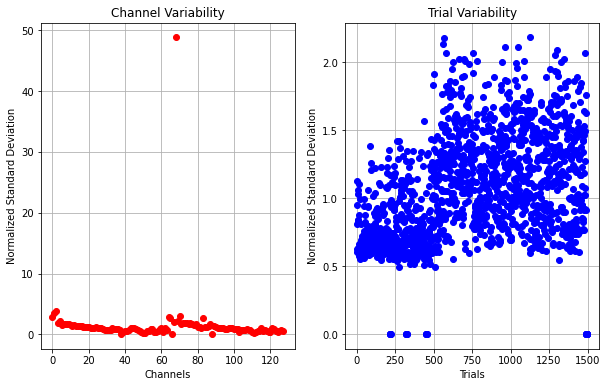

In [7]:
eegstd = np.std(stimdata, axis=1)
chanstd = np.sum(eegstd[:, 0:nEEGchan], axis=0)
trialstd = np.sum(eegstd[:, 0:nEEGchan], axis=1)
if plot == "y":
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].plot(chanstd / np.median(chanstd), "ro")
    ax[0].set_title("Channel Variability")
    ax[0].set_xlabel("Channels")
    ax[0].set_ylabel("Normalized Standard Deviation")
    ax[0].grid()
    ax[1].plot(trialstd / np.median(trialstd), "bo")
    ax[1].set_xlabel("Trials")
    ax[1].set_ylabel("Normalized Standard Deviation")
    ax[1].set_title("Trial Variability")
    ax[1].grid()
    plt.show(block=False)

In [8]:
# threshhold trials by standard deviation criteria and remove them.
# in principle you could threshold channels this way too.  But, I
# think with 32 channels you need to avoid that.  With 128 you could.

badtrials_eeg = np.where(trialstd / np.median(trialstd) > var_threshold)[0]
goodtrials = np.setdiff1d(range(nfeat), badtrials_eeg)
badtrials_noresponse = np.where(stimresponsechoice == 0)[0]
goodtrials = np.setdiff1d(goodtrials, badtrials_noresponse)
#threshold channels 
badchan_eeg = np.where(chanstd/np.median(chanstd) > chan_threshold)[0]
badchan_eeg = np.setdiff1d(badchan_eeg,fail_chans)
#remove trials with no eeg (normally early termination of experiment)
blanktrial = [np.argwhere(goodtrials == i)[0][0] for i in range(stimdata.shape[0]) if np.sum(stimdata[i,:,:]) == 0]
goodtrials = np.delete(goodtrials,blanktrial,axis = 0)

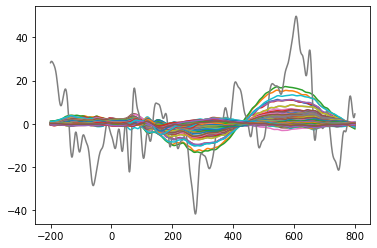

[68]


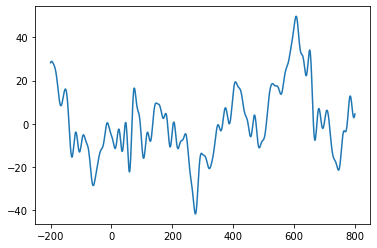

In [9]:
erpsegmented = np.mean(stimdata[goodtrials,:,:],axis = 0)
plt.plot(time,erpsegmented[:,use_chans])
plt.show()
if any(badchan_eeg):
    plt.plot(time,erpsegmented[:,badchan_eeg])
    print(badchan_eeg)
    plt.show()

In [10]:
# reshape gooddata for ICA

dubious_chans = np.unique(np.concatenate((np.array(eyechans),badchan_eeg)))
# cleandata,Mix, UnMix,goodcomponents,corrsmax, chanvar_components = ica_cleanup(stimdata[goodtrials,:,:],dubious_chans,corr_threshold = 0.4,icavar_threshold = 0.5,maxiter = 10000, tolerance = 1e-6):
cleandata,Mix, UnMix,goodcomponents,corrsmax, chanvar_components = ica_cleanup(stimdata[goodtrials,:,:],dubious_chans,fail_chans)
if diagnostics == 'y':
        plt.plot(use_chans,corrsmax,'ro')
        plt.title('Correlation Between ICA and Frontal Channels')
        plt.show()
        plt.figure()
        plt.plot(chanvar_components)
        plt.title('Maximum Single Channel Variance')

In [ ]:
cleandata = stimdata[goodtrials,:,:]
erp_clean = np.mean(cleandata, axis=0)
erp_clean = avref(erp_clean,fail_chans)
erp_clean = baselinecorrect(erp_clean,range(200))

<Figure size 432x288 with 0 Axes>

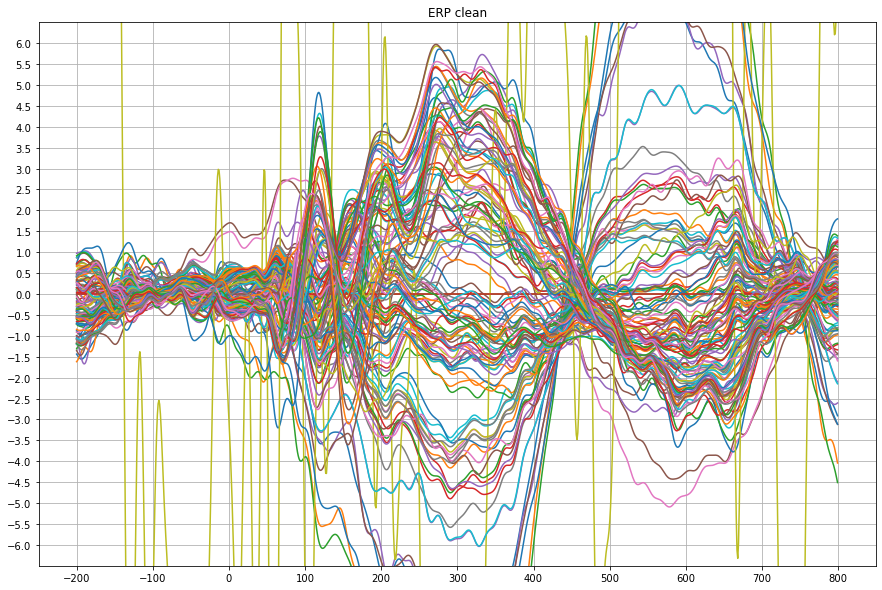

In [ ]:
if plot == "y":
    plt.figure()    
    plt.figure(figsize = (15,10))   
    plt.plot(time, erp_clean[:,:])
    plt.xticks(np.arange(-200,900,100))
    plt.ylim([-6.5,6.5])
    plt.yticks(np.arange(-6,6.5,0.5))
    plt.grid()
    fn = f'data/Subject{sub}/Subject{sub}Session{ses}MeanPlot.png'
    # plt.savefig(fn,format='png')
    plt.title("ERP clean")# 42,83


lo_f = 15
hi_f = 1
sos_low, w_low, h_low = makefiltersos(sr, lo_f, lo_f+5, gp=3, gs=20)
eegtemp = signal.sosfiltfilt(sos_low,cleandata,axis=0, padtype='odd')
sos_high, w_high, h_high = makefiltersos(sr, hi_f, hi_f/2, gp=3, gs=10)
cleandata = signal.sosfiltfilt(sos_high,eegtemp,axis=0, padtype='odd')

<Figure size 432x288 with 0 Axes>

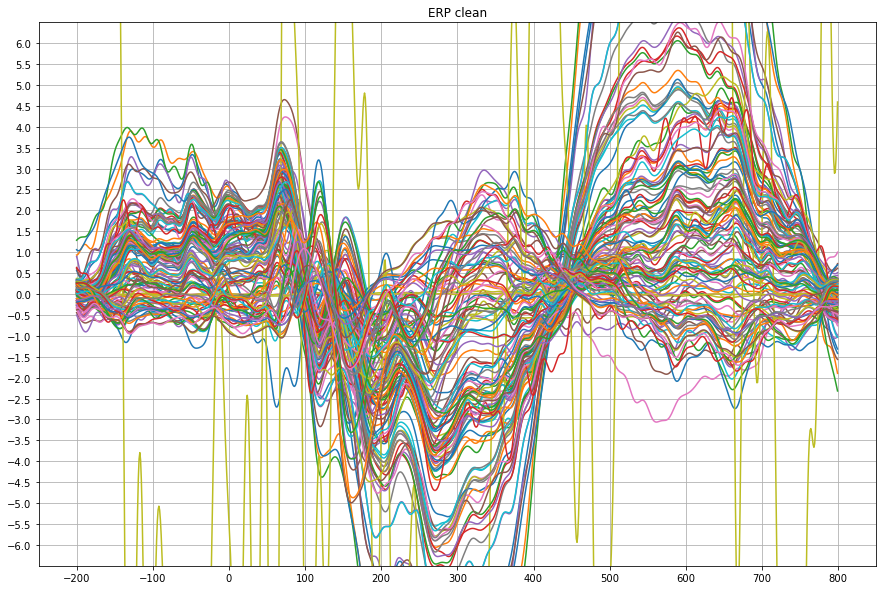

In [ ]:
if plot == "y":
    plt.figure()    
    plt.figure(figsize = (15,10))   
    plt.plot(time, np.mean(cleandata,axis=0))
    plt.xticks(np.arange(-200,900,100))
    plt.ylim([-6.5,6.5])
    plt.yticks(np.arange(-6,6.5,0.5))
    plt.grid()
    fn = f'data/Subject{sub}/Subject{sub}Session{ses}MeanPlot.png'
    # plt.savefig(fn,format='png')
    plt.title("ERP clean")

In [ ]:
if any(fail_chans) and any(badchan_eeg):
    fail_chans = np.concatenate([fail_chans,badchan_eeg])
elif badchan_eeg:
    fail_chans = badchan_eeg

In [ ]:
for j in range(np.shape(cleandata)[0]):
	trial = cleandata[j,:,:]
	trial = avref(trial,fail_chans)
	trial = baselinecorrect(trial,range(200))
	cleandata[j,:,:] = trial 
finaldata = np.zeros(stimdata.shape)  # An alternative would be to replace the data in epochdata
finaldata[goodtrials, :, :] = cleandata


['Occupation'] 103
['Workclass'] 102
['Gender'] 101
['Hours per Week'] 102
['Marital Status'] 100
['Age'] 96
['Race'] 102
['Highest Degree'] 98
['Response Cue'] 268
['Pass or Keep'] 271


/tmp/ipykernel_378730/299571888.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


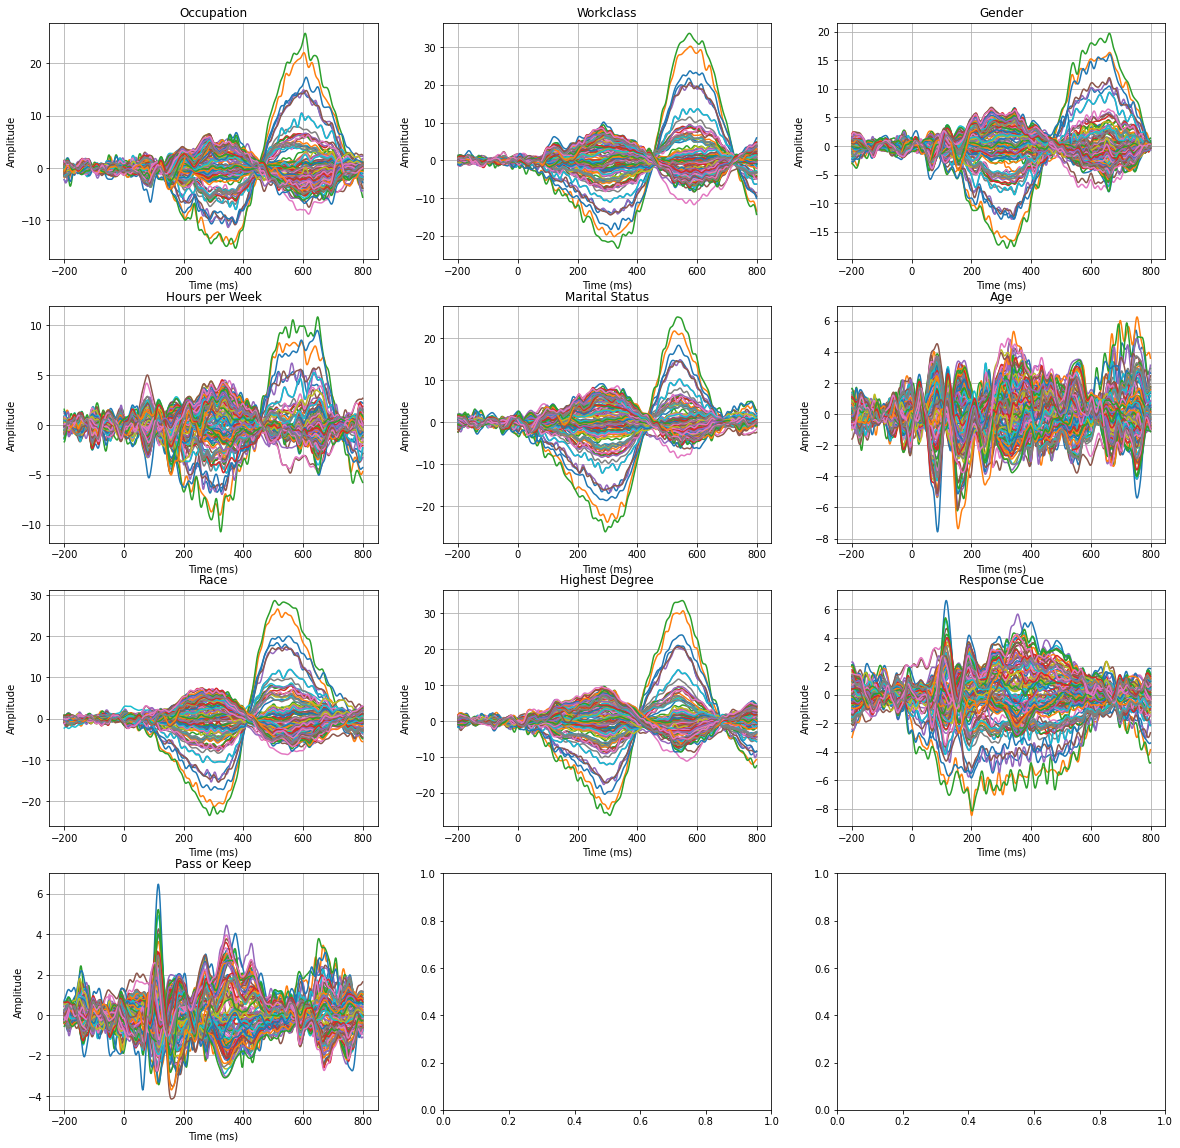

In [ ]:
feats=['Occupation', 'Workclass', 'Gender', 'Hours per Week', 'Marital Status', 'Age', 'Race', 'Highest Degree','Response Cue','Pass or Keep']
fig,axs = plt.subplots(4,3,figsize=(20,20))
axs = np.ravel(axs)
finalfeatarray = featarray[goodtrials]
for i,f in enumerate(feats):
    featind = np.where(np.char.find(finalfeatarray.astype(str), f)>=0)[0] #### finds indices feature is
    x = np.nanmean(finaldata[featind],axis = 0)
    print(np.unique([i.split(': ')[0] for i in finalfeatarray[featind]]),len(finaldata[featind]))
    #x = avref(x)
    #x = baselinecorrect(x,range(200))
    axs[i].set_title(f)
    axs[i].plot(time,x)
    axs[i].grid()
    axs[i].set_ylabel('Amplitude')
    axs[i].set_xlabel('Time (ms)')
axs = np.reshape(axs, (4,3))
fn = f'data/Subject{sub}/Subject{sub}Session{ses}FeatPlot.png'
# plt.savefig(fn,format='png')
fig.show()

In [ ]:
outpath = 'cleaned/'
outname = f'{sub}SS{ses}_cleaned.hdf'
outdict['eeg'] = finaldata
icastat = dict()
icastat['dubious_channels'] = dubious_chans
icastat['good_trials'] = goodtrials
icastat['Mix'] = Mix
icastat['UnMix'] = UnMix
icastat['Good_Components'] = goodcomponents
icastat['ChannelVariance_Components'] = chanvar_components
icastat['MaxDubiousChannelCorrelation'] = corrsmax
outdict['icastat'] = icastat
try:
    savemat(outpath+outname,outdict,store_python_metadata=True)
except OSError:
    os.mkdir(outpath)
    savemat(outpath+outname,outdict,store_python_metadata=True)